In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Markdown as md

In [3]:
import process_interferometry 
process_interferometry.run_for_old_shots()

processing shots:   0%|          | 0/5000 [00:00<?, ?it/s]

In [4]:
# read pickle file
# no need to rearange index and parse datetime values

df = pd.read_pickle('OldInterferometryDF.pkl',)
df.n_bad_peaks.apply(pd.to_numeric);
df

time                                            session  is_plasma  \
shot_no                                                                       
20231    None  Something failed, shot:20231   <br>web_path se...       True   
20233    None  Something failed, shot:20233   <br>web_path se...       True   
20234    None  Something failed, shot:20234   <br>web_path se...       True   
20235    None  Something failed, shot:20235   <br>web_path se...       True   
20236    None  Something failed, shot:20236   <br>web_path se...       True   
...       ...                                                ...        ...   
26465    None                      TrainingCourses/FUMTRAIC/18\n       True   
26466    None                      TrainingCourses/FUMTRAIC/18\n       True   
26467    None                      TrainingCourses/FUMTRAIC/18\n       True   
26468    None                      TrainingCourses/FUMTRAIC/18\n       True   
26469    None                      TrainingCourses/FUMTRAIC/18\n       True   

           U_loop     I_pl     B_tor  p_pre_discharge  \
shot_no                                                 
20231     7.68066  1668.79  0.144042        14.039860   
20233     9.52026  1039.55  0.260551        20.468896   
20234     7.74109  1260.51  0.133644        15.101321   
20235     7.97607  1454.01  0.135606        13.979065   
20236     7.93579  1394.22  0.133690        14.148101   
...           ...      ...       ...              ...   
26465     6.17004  4870.18  0.241145        44.671352   
26466     5.97534  4700.38  0.242630        32.110964   
26467    10.03050  1457.83  0.083418        29.105398   
26468         NaN      NaN       NaN        19.905698   
26469    10.25880  1383.56  0.083894        25.568685   

         has_complete_interferometry_data density_analog_valid  \
shot_no                                                          
20231                                True                 None   
20233                                True                 None   
20234                                True                 None   
20235                                True                 None   
20236                                True                 None   
...                                   ...                  ...   
26465                                True                 None   
26466                                True                 None   
26467                                True                 None   
26468                                True                 None   
26469                                True                 None   

        positive_analog  ... negative_in_plasma_original density_fix_valid  \
shot_no                  ...                                                 
20231              None  ...                       False             False   
20233              None  ...                       False             False   
20234              None  ...                       False             False   
20235              None  ...                       False             False   
20236              None  ...                       False              True   
...                 ...  ...                         ...               ...   
26465              None  ...                       False             False   
26466              None  ...                       False              True   
26467              None  ...                       False             False   
26468              None  ...                        None              None   
26469              None  ...                       False             False   

        positive_fix  zero_fix negative_in_plasma_fix density_no_fix_valid  \
shot_no                                                                      
20231      10.242131     False                   True                False   
20233      72.250140     False                  False                False   
20234     100.000000     False                  False

In [7]:
# Filter shots witouth plasma and with incomplete interferometry data
df = df[(df.is_plasma == True)] # (df.has_complete_interferometry_data == True) & 

In [43]:
validity = lambda x : x.astype(bool).sum() / x.size * 100.


validity_analog  = validity(df.density_analog_valid)
validity_original = validity(df.density_original_valid)
validity_no_fix = validity(df.density_no_fix_valid)
validity_fix = validity(df.density_fix_valid)


md("""
Processed %d shots in range %d-%d :
- %.2f%% of analog processed density is valid  
- %.2f%% of original digitally processed density is valid  
- %.2f%% of digitally non-fixed (new alg)  density is valid  
- %.2f%% of digitally fixed  density is valid  
""" % (len(df),df.index[0],df.index[-1], validity_analog, validity_original, validity_no_fix, validity_fix))


Processed 4999 shots in range 20231-26469 :
- 0.00% of analog processed density is valid  
- 27.89% of original digitally processed density is valid  
- 15.88% of digitally non-fixed (new alg)  density is valid  
- 25.57% of digitally fixed  density is valid  


In [9]:
from  process_interferometry import *

Histogram of number of repairs

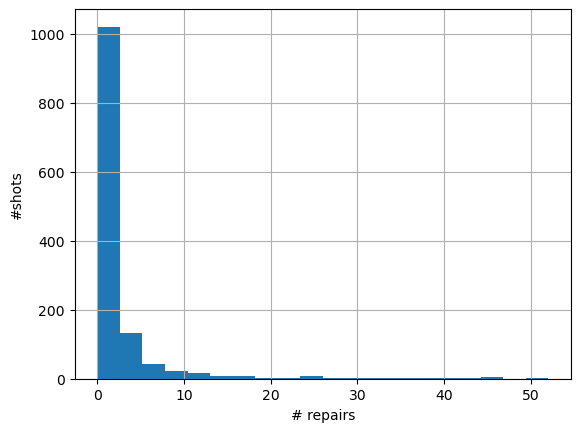

In [17]:
fixed = df[df.density_fix_valid == True]
fixed = fixed.sort_values('n_bad_peaks')
fig, ax = plt.subplots()
fixed.n_bad_peaks.hist(bins = 20, ax = ax)#, range = (0,30))
ax.set_ylabel("#shots")
ax.set_xlabel("# repairs")
plt.show()

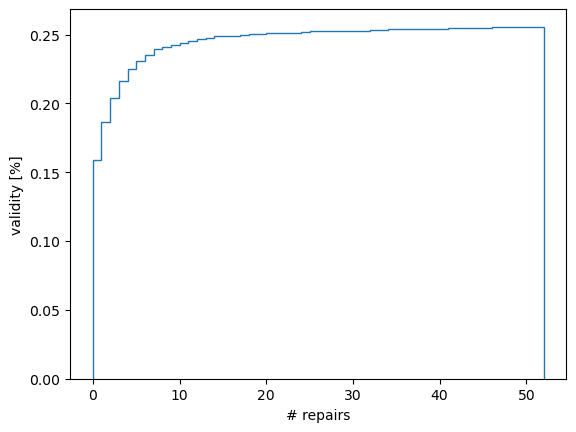

In [18]:
count, edges = np.histogram(fixed.n_bad_peaks, bins=fixed.n_bad_peaks.max())
count = np.cumsum(count) / df.n_bad_peaks.count()
plt.stairs(count, edges)
plt.xlabel('# repairs')
plt.ylabel('validity [%]');

/home/marek/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


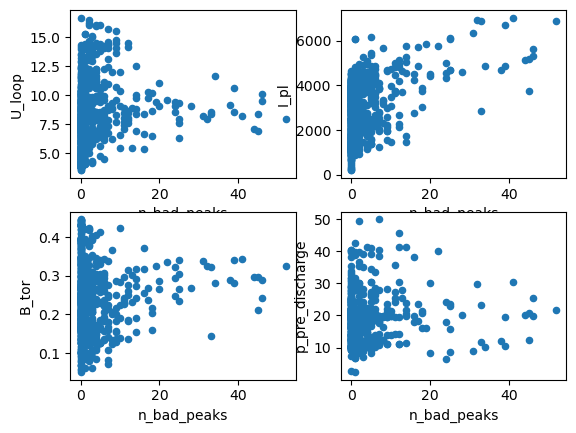

In [31]:
fixed_slice = fixed[["U_loop", "I_pl", "B_tor", "p_pre_discharge","n_bad_peaks"]]
fixed_slice = fixed_slice[fixed_slice.p_pre_discharge >0]
fig, axs = plt.subplots(2,2)
axs = axs.flatten()
for ax, col in zip(axs,fixed_slice.columns[:-1]):
    fixed_slice.plot.scatter(x = 'n_bad_peaks', y = col, ax = ax)

In [ ]:
#--------
#
# Some plots for tuning and testing parameters

In [ ]:
def adv_plot(shot_no:int, ax : plt.Axes = None, kind : str = 'digital', add_info = True, **kargs):
    if not ax:
        fig, ax = plt.subplots()
    shot_data = get_shot_data(shot_no)
    
    if kind  == 'digital':
        density = shot_data.digital_interferometer_original
    elif kind == "analog" :
        density  = shot_data.analog_interferometer
    elif kind == 'digital_fixed' :
        shot_data.compute_corrected_density()
        density  = shot_data.digital_interferometer_new_fixed
    elif kind == 'digital_nofix':
        shot_data.compute_corrected_density()
        density = shot_data.digital_interferometer_new_no_fix
    else:
        return
    if density is None:
        print('ne')
        return
    
    density.plot(ax = ax, **kargs)
    
    if not add_info:
        return ax
    threshold = density.max() * .05
    threshold = np.max([5e16,threshold]) 
    
    step = .5
    if shot_data.is_plasma:
        s_end = density.index[-1] - shot_data.plasma_end
    else:
        s_end = 5
    for t_slice in np.arange(0,s_end,step)[:-2]:
        t_start = density.index[-1] - t_slice - step
        t_end  = density.index[-1] - t_slice
        is_zero = is_zero_in_slice(density, threshold=threshold, 
                                 start = t_start, end = t_end)
        color = '#ABB2B9' if is_zero else "#E74C3C"
        ax.axvspan(t_start,t_end, color = color, alpha = .5)
    if shot_data.is_plasma:
        if kind  == 'digital':
            negative = df.loc[shot_no].positive_original
        elif kind == "analog" :
            negative = df.loc[shot_no].positive_analog
        elif kind == 'digital_fixed' :
            negative = df.loc[shot_no].positive_fix

        
#         ax.text(0.25, 0.25, f'{negative:.1f}%>0', horizontalalignment='center',
#                 verticalalignment='center', transform=ax.transAxes,
#                 bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=1'))

        ax.axvline(shot_data.plasma_start, c = 'green')
        ax.axvline(shot_data.plasma_end , c = 'green')
        
    ax.axhline(0, c = 'k', ls = '--')
    
    return ax

In [ ]:
#print(len(fixed))
for shot_no in fixed[fixed.n_bad_peaks>=1].index[:300:30]:
    ax = adv_plot(shot_no, kind = 'digital', color = 'k', alpha = .5)
    adv_plot(shot_no, kind = 'digital_fix', ax = ax, add_info=False, color = 'b', alpha = .7 )
    adv_plot(shot_no, kind = 'digital_nofix', ax = ax, add_info=False, color = 'r', alpha = .7)
    ax.set_title(shot_no)
    ax.text(.05,.5, f"#repairs: {fixed.loc[shot_no].n_bad_peaks}", transform=ax.transAxes,)
    shot_data = get_shot_data(shot_no)
    shot_data.compute_corrected_density()
    ax.set_ylim(top = shot_data.digital_interferometer_new_fixed.max()*1.4)
    plt.show()

In [ ]:
fixed_bad = df[(df.negative_in_plasma_original == True) & (df.is_plasma)]
fixed_bad = fixed_bad.sort_values('n_bad_peaks')
print(len(fixed_bad))
for shot_no in fixed_bad.index[-40:-10]:
    ax = adv_plot(shot_no, kind = 'digital', color = 'k', alpha = .7)
    adv_plot(shot_no, kind = 'digital_fixed', ax = ax, add_info=False, color = 'b', alpha = .7 )
    adv_plot(shot_no, kind = 'digital_nofix', ax = ax, add_info=False, color = 'r', alpha = .7)
    ax.set_title(shot_no)
    ax.text(.2,.5, f"{fixed_bad.loc[shot_no].n_bad_peaks} fixes")
    shot_data = get_shot_data(shot_no)
    shot_data.compute_corrected_density()
    #ax.set_ylim(top = shot_data.digital_interferometer_new_fixed.max()*1.4)
    plt.show()

In [ ]:
for shot_no in df[(df.density_original_valid == False) & (df.density_fix_valid == True)].index[:10]:
    ax = adv_plot(shot_no, kind = 'digital', color = 'k', alpha = .1)
    adv_plot(shot_no, kind = 'digital_fixed', ax = ax, add_info=False, color = 'b', alpha = .7 )
    adv_plot(shot_no, kind = 'digital_nofix', ax = ax, add_info=False, color = 'r', alpha = .7)
    ax.set_title(shot_no)

In [ ]:
for shot_no in df[(df.density_fix_valid == True) ].index[:10]: # & (df.zero_digital == True)
    ax = adv_plot(shot_no, kind = 'digital', color = 'k', alpha = .1)
    adv_plot(shot_no, kind = 'digital_fixed', ax = ax, add_info=False, color = 'b', alpha = .7 )
    adv_plot(shot_no, kind = 'digital_nofix', ax = ax, add_info=False, color = 'r', alpha = .2)
    ax.set_title(shot_no)

In [ ]:
for shot_no in df[(df.density_fix == False) & (df.density_digital == False)].index[::10]:
    ax = adv_plot(shot_no, kind = 'digital_fixed')
    adv_plot(shot_no, kind = 'digital', ax = ax, add_info=False)
    ax.set_title(shot_no)
    plt.show()

In [ ]:
for shot_no in df[df.density_fix == False].index:
    ax = adv_plot(shot_no, kind = 'digital_fixed')
    ax.set_title(shot_no)